# 5 | Acoustic-Box Part 2 – Practice and Exercise

__Practice__

The practice part should help you to additionally prepare for the workshops and the exercises by covering the contents of the lecture, containing additional minor tasks and questions. The solutions of these minor tasks of the practice part will not be graded, but questions regarding the following contents are addressed in the workshops. It is therefore recommended that you are able to address the presented tasks and questions, since answers to questions during the workshops are part of the participation grade.

__Exercise__

The assignments of the exercise part are explicitly labeled with "Title of assignement (Exercise)". The solutions of the exercise assignments will be graded. Some of the tasks (mostly implementation tasks) will be automatically graded with validation tests, make sure that your code can be executed without error messages (it doesn't guarantee that your submitted solutions are correct).

__Lab-experiment and setup__

Exercise and Practice 5 continue part 4, you could reuse your implementations and solutions from some of the previous tasks, if necessary.

__Note: Write down your group name including group members and give a short statement on the distribution of the work in the markdown cell below.__

YOUR ANSWER HERE

In [1]:
# import necessary modules

import numpy as np

# to prevent warning from matplotlib
import os
#os.environ['MPLCONFIGDIR'] = '/tmp'

import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir

## 1 Load and display the FRFs

Load all FRFs calculated in Exercise 4 into your workspace or calculate them again.

**Task:** Calculate the __averaged FRFs__ of __all__ excitation points (EX). Use the code from the previous exercise and paste it below!

In [2]:
# paste the functions for reading in the data here

# YOUR CODE HERE
def read_labview_txt(file_path):

    '''
    input:
        file_path ... path of the labview measurement data file
    
    output:
        data ... Read data as list of lists in the format [t, F, a], t ... time in second, F ... force sensor output signal in V, a ... acceleration sensor output signal in V
    '''
    # YOUR CODE HERE
    with open(filepath, 'r') as f:
        # Skip header lines
        for _ in range(23):
            next(f)


        time = []
        force = []
        acc = []

        for line in f:
            v = line.strip().split('\t')
            if len(v) < 3:
                continue
            try:
                # Replace commas with dots and convert to float
                t_val = float(v[0].replace(',', '.'))
                f_val = float(v[1].replace(',', '.'))
                a_val = float(v[2].replace(',', '.'))

                time.append(t_val)
                force.append(f_val)
                acc.append(a_val)
            except ValueError:
                continue

    data = [np.array(time), np.array(force), np.array(acc)]
    

    
    # Return the read data as a list of different data series [t,F,a]
    return data

In [3]:
# Define important measurement parameters

# Gain on the Force channel
GAIN_F = 0
# YOUR CODE HERE
GAIN_F = 0.1

# Gain on the Acceleration channel
Gain_A = 0
# YOUR CODE HERE
Gain_A = 0.01


# Sampling rate of the measurement
SAMPLING_RATE = 0
# YOUR CODE HERE
SAMPLING_RATE = 50000

In [4]:
# Create a python dictionary to store the measurement data sorted by excitaton point 1_1, 1_2, ... , 6_3, 6_4
from operator import itemgetter

data = dict()
dir_filtered = "Data/filtered_data/"
dir_5_1 = "Data/5_1_data/"

# Assume these are defined elsewhere:
# GAIN_F = ...
# Gain_A = ...
# def read_labview_txt(filepath): ...

# --- 1. Load all files from filtered_data ---
for filename in os.listdir(dir_filtered):
    if filename.endswith(".txt") and "Ex-" in filename:
        excitation_point = filename.split("Ex-")[-1].replace(".txt", "").strip()
        filepath = os.path.join(dir_filtered, filename)

        try:
            t, f, a = read_labview_txt(filepath)
            f /= GAIN_F
            a /= Gain_A

            if excitation_point not in data:
                data[excitation_point] = []
            data[excitation_point].append((t, f, a))

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

# --- 2. Load ONLY files with indices [0, 1, 5, 7] from 5_1_data ---
selected_indices = [0, 1, 5, 7]
data["5_1"] = []

# Get sorted list of files (to make indices meaningful)
files_5_1 = sorted([f for f in os.listdir(dir_5_1) if f.endswith(".txt")])

for idx in selected_indices:
    if idx < len(files_5_1):
        filename = files_5_1[idx]
        filepath = os.path.join(dir_5_1, filename)

        try:
            t, f, a = read_labview_txt(filepath)
            f /= GAIN_F
            a /= Gain_A

            data["5_1"].append((t, f, a))

        except Exception as e:
            print(f"Error processing 5_1 file {filename}: {str(e)}")
    else:
        print(f"Index {idx} out of range for files in 5_1_data.")

# --- 3. Print summary ---
for key in sorted(data.keys()):
    print(f"{key} Count: {len(data[key])}")

1_1 Count: 4
1_2 Count: 4
1_3 Count: 4
1_4 Count: 4
2_1 Count: 4
2_2 Count: 4
2_3 Count: 4
2_4 Count: 4
3_1 Count: 4
3_2 Count: 4
3_3 Count: 4
3_4 Count: 4
4_1 Count: 4
4_2 Count: 4
4_3 Count: 4
4_4 Count: 4
5_1 Count: 4
5_2 Count: 4
5_3 Count: 4
5_4 Count: 4
6_1 Count: 4
6_2 Count: 4
6_3 Count: 4
6_4 Count: 4


__Task:__ Transform the time signal data in the frequency domain using FFT.

__Hints:__ Don't forget to properly scale the FFT amplitude. (Rule: Mulitply the FFT amplitude by 2 and divide by the sample length)

In [5]:
# fourier transfrom the time signal data

fft_data = dict()
shape = (13001,4)

# YOUR CODE HERE
def compute_fft_data(data, sampling_rate,t):
    fft_data = dict()

    for key, datasets in data.items():
        # Determine number of samples for 0.2s
        t_example = datasets[0][0]
        N = len(t)
        n_freq = N // 2 + 1
        freq = np.fft.rfftfreq(N, d=1 / sampling_rate)
        omega_sq = (2 * np.pi * freq) ** 2
        omega_sq[omega_sq == 0] = 1e-12  # avoid divide-by-zero

        fft_force = np.zeros((n_freq, len(datasets)), dtype=np.complex_)
        fft_acc = np.zeros((n_freq, len(datasets)), dtype=np.complex_)
        accelerance = np.zeros((n_freq, len(datasets)), dtype=np.complex_)
        receptance = np.zeros((n_freq, len(datasets)), dtype=np.complex_)

        for i, (t, f, a) in enumerate(datasets):
            # Slice signals to length N
            f_fft =2* np.fft.rfft(f[:N])/N
            a_fft = 2*np.fft.rfft(a[:N])/N

            fft_force[:, i] = f_fft
            fft_acc[:, i] = a_fft

            with np.errstate(divide='ignore', invalid='ignore'):
                acc = np.zeros_like(a_fft)
                rec = np.zeros_like(a_fft)

                acc[f_fft != 0] = a_fft[f_fft != 0] / f_fft[f_fft != 0]
                denom = omega_sq * f_fft
                rec[denom != 0] = a_fft[denom != 0] / -denom[denom != 0]

                accelerance[:, i] = acc
                receptance[:, i] = rec

        fft_data[key] = {
            'force_fft': fft_force,
            'acc_fft': fft_acc,
            'accelerance': accelerance,
            'receptance': receptance
        }

    return fft_data, freq

fft_data, freq = compute_fft_data(data, SAMPLING_RATE,t)

__Task:__ Compute the average FRFs by taking the average of the FFT signals

In [6]:
# compute average FRFs and store it as python dictionary

fft_data_avg = dict()

# YOUR CODE HERE
def average_fft_data(fft_data):
    """
    Computes the average accelerance and receptance over 4 measurements
    for each excitation point.

    Parameters:
    - fft_data: dict with keys as excitation points and values containing:
        - 'accelerance': ndarray of shape (n_freq, 4)
        - 'receptance': ndarray of shape (n_freq, 4)

    Returns:
    - fft_data_avg: dict with averaged accelerance and receptance
    - frf_avg: dict (flat structure) with same averaged data
    """
    fft_data_avg = {}
    frf_avg = {}

    for key in fft_data:
        accel = fft_data[key]['accelerance']   # shape: (n_freq, 4)
        recep = fft_data[key]['receptance']    # shape: (n_freq, 4)

        avg_accel = np.mean(accel, axis=1)     # shape: (n_freq,)
        avg_recep = np.mean(recep, axis=1)     # shape: (n_freq,)

        fft_data_avg[key] = {
            'accelerance_avg': avg_accel,
            'receptance_avg': avg_recep
        }

        frf_avg[key] = {
            'accelerance': avg_accel,
            'receptance': avg_recep
        }

    return fft_data_avg, frf_avg

fft_data_avg, frf_avg = average_fft_data(fft_data)

__Task:__  Plot the averaged FRFs (only Receptance) of all excitation points in a frequency range of 0-500 Hz.

__Hint:__ `%matplotlib widget` enables interactive plots where the x and y coordinates of the point of the plot where your mouse hovers are displayed. Therefore you can easily identify the frequency values in the plots. Be careful to either don't remove the xticklabels from the plot or use `ax0.get_xaxis().set_visible(False)`, otherwise the x coordinate won't be displayed.

In [7]:
# implement the function for plotting the averaged FRFs here

import matplotlib as mpl
mpl.rc('axes',grid=True,linewidth=0.5) # medium axes frame
mpl.rc('grid',linewidth=0.5,linestyle=':') # thin grid lines
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import matplotlib as mpl
mpl.rc('axes', grid=True, linewidth=0.5)  # Medium axes frame
mpl.rc('grid', linewidth=0.5, linestyle=':')  # Thin grid lines

import matplotlib.pyplot as plt
import numpy as np

def plot_frf(f, R):
    '''
    Plot the real, imaginary, amplitude, and phase of frequency response functions (FRFs).

    Parameters:
        f : np.ndarray
            Frequency vector (1D array)
        R : np.ndarray
            Frequency response functions (2D array: len(f) x N_signals)

    Returns:
        fig : matplotlib.figure.Figure
            The figure object containing the subplots.
        axs : np.ndarray of matplotlib.axes._subplots.AxesSubplot
            Array of subplot axes: [real, amplitude, imaginary, phase]
    '''

    # Limit plot to frequency range ≤ 4000 Hz and display up to 500 Hz
    freq_limit = f <= 4000
    f_plot = f[freq_limit]

    # Set up 2x2 subplot figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    axs = axs.flatten()

    # Define colors for up to 4 signals
    colors = ['r', 'g', 'b', 'purple']

    # Plot Real Part
    for i in range(R.shape[1]):
        axs[0].plot(f_plot, R[freq_limit, i].real, color=colors[i % len(colors)], alpha=0.7)
    axs[0].set_ylabel("Real Part")
    axs[0].set_xlim(0, 500)
    axs[0].set_title("Real Part")

    # Plot Amplitude (Magnitude)
    for i in range(R.shape[1]):
        mag = np.abs(R[:, i])
        axs[1].semilogy(f_plot, mag[freq_limit], color=colors[i % len(colors)], label=f"Signal {i+1}", alpha=0.7)
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlim(0, 500)
    axs[1].set_title("Amplitude")
    axs[1].legend()

    # Plot Imaginary Part
    for i in range(R.shape[1]):
        axs[2].plot(f_plot, R[freq_limit, i].imag, color=colors[i % len(colors)], alpha=0.7)
    axs[2].set_xlabel("f in Hz")
    axs[2].set_ylabel("Imag Part")
    axs[2].set_xlim(0, 500)
    axs[2].set_title("Imaginary Part")

    # Plot Phase (in degrees)
    for i in range(R.shape[1]):
        phase = np.angle(R[:, i], deg=True)
        axs[3].plot(f_plot, phase[freq_limit], color=colors[i % len(colors)], alpha=0.7)
    axs[3].set_xlabel("f in Hz")
    axs[3].set_ylabel("φ in deg")
    axs[3].set_xlim(0, 500)
    axs[3].set_title("Phase")

    plt.tight_layout()
    plt.show()

    return fig, np.array(axs)

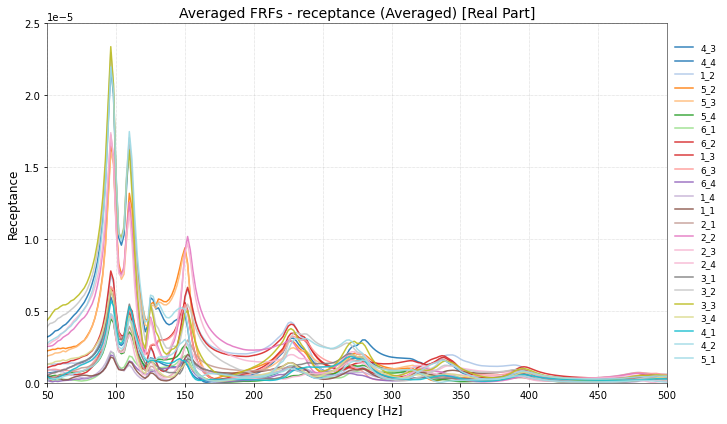

In [8]:
# YOUR CODE HERE
import matplotlib.cm as cm
title_name = "Averaged FRFs - receptance (Averaged) [Real Part]"

# Extract frequency from any key
first_key = next(iter(fft_data_avg))
N = 2 * (fft_data_avg[first_key]['receptance_avg'].shape[0] - 1)
f = np.fft.rfftfreq(N, d=1 / SAMPLING_RATE)
mask = f <= 500
f_plot = f[mask]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = cm.get_cmap('tab20', len(fft_data_avg))

# Plot each averaged accelerance curve (real part)
for i, AV_TP in enumerate(fft_data_avg):
    R = fft_data_avg[AV_TP]['receptance_avg']
    ax.plot(f_plot, np.abs(R[mask]), label=f"{AV_TP}", linewidth=1.5, alpha=0.9, color=colors(i))

# Styling
ax.set_title(title_name, fontsize=14)
ax.set_xlabel("Frequency [Hz]", fontsize=12)
ax.set_ylabel("Receptance", fontsize=12)
ax.set_xlim(50, 500)
ax.set_ylim(0, 2.5e-5)
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

# Legend (outside the plot)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, ncol=1, frameon=False)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on right for legend
plt.show()

**Questions:**

* Why is it okay to consider a frequency range from 0-500Hz and to cut off higher frequencies? 


YOUR ANSWER HERE

## 2 Peak-Picking and Eigenfrequencies - Exercise (2 Points)

You can select the peaks based on the absolute values, the zeros of the real parts or the extreme values of the imaginary parts, as describe in the lecture. Note that you can use the FRFs of several different points for peak picking to identify as many natural frequencies as possible. Use excitation points for which proper and realiable measurement signals are available!

__Task:__ Pick 10 peaks based on the figures above and mark them in a plot.
* Show the plots from which you picked the peaks (0.5 Points)
* Store the corresponding frequencies to the array __fn__ (0.5 Points)
* Mark the peaks in the plots respectively (1 Point)

__Hints:__
* Especially take a look at figures with nice runs like EX 2_2, 2_3, 3_3, 5_2, 5_4, 6_2, 6_4, etc.
* Note that these peaks could differ from the actual eigenfrequencies

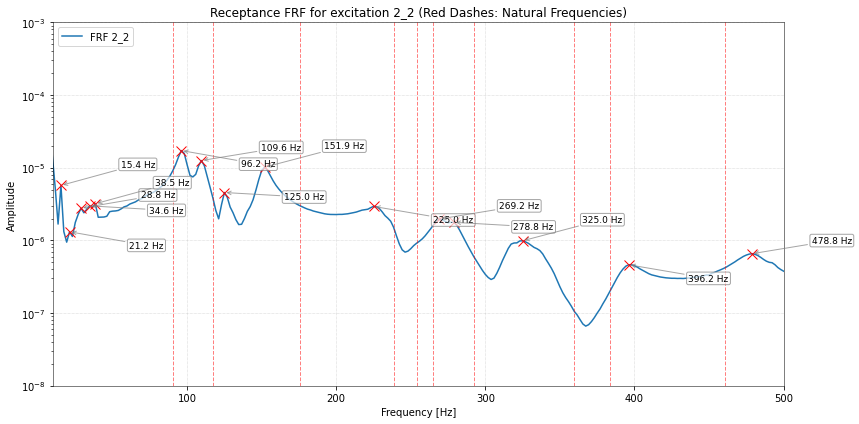

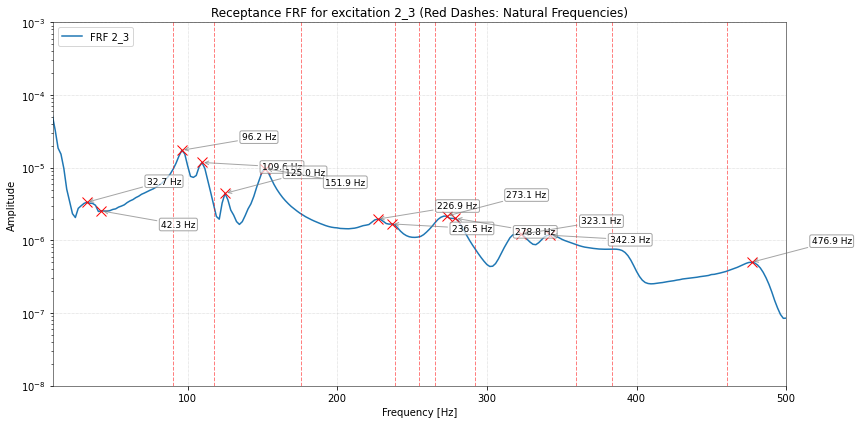

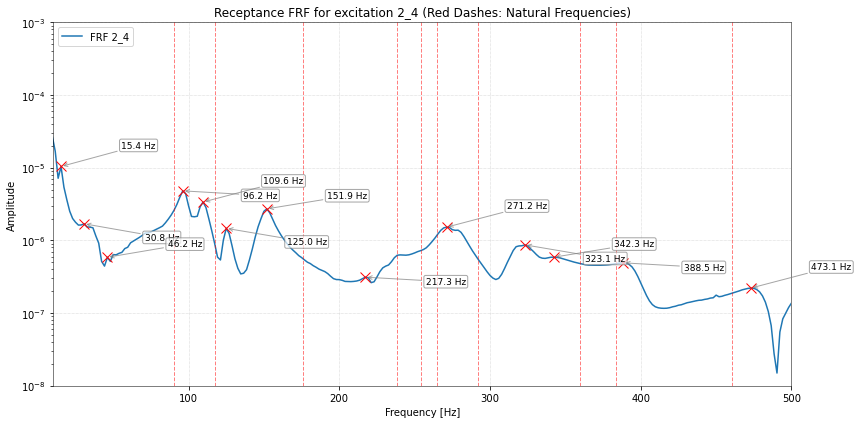

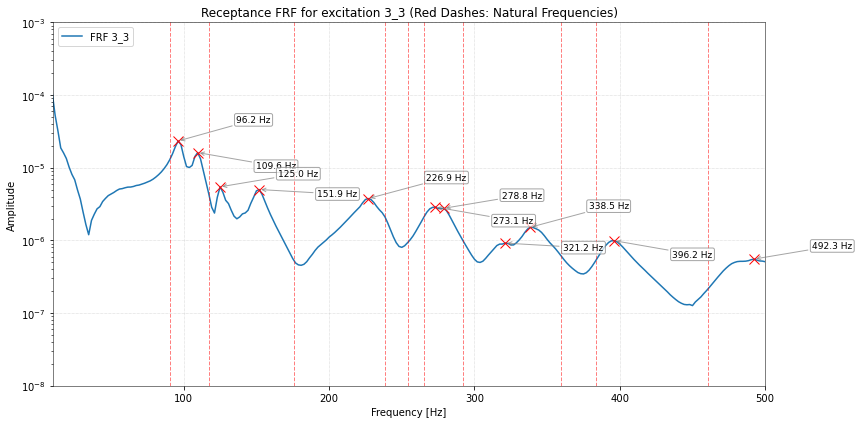

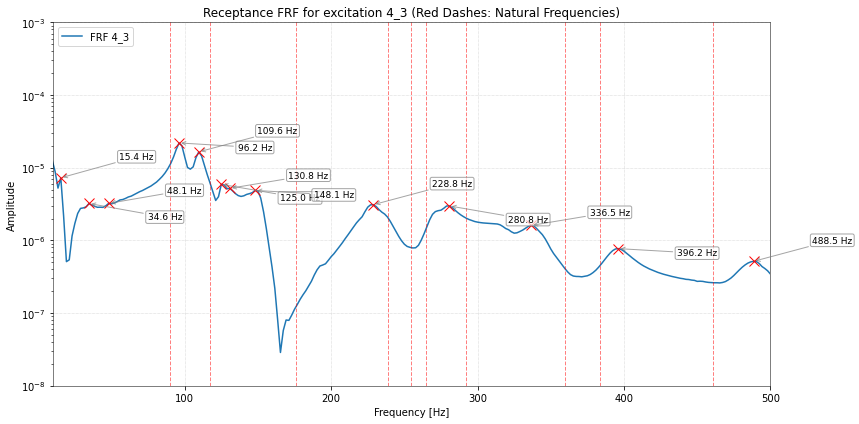

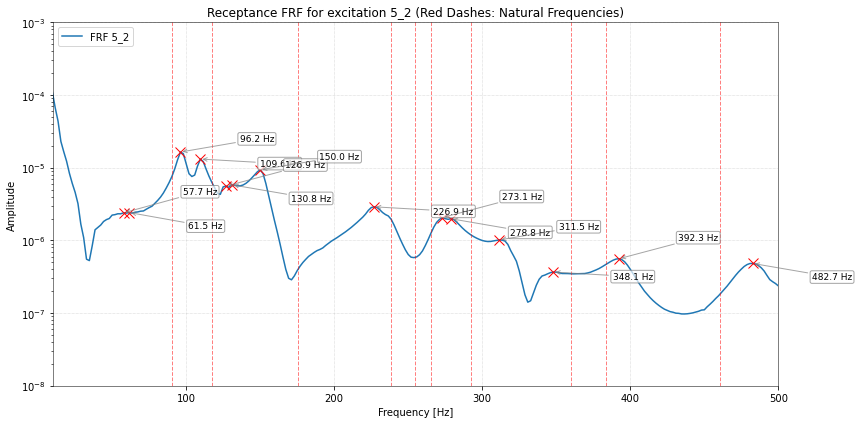

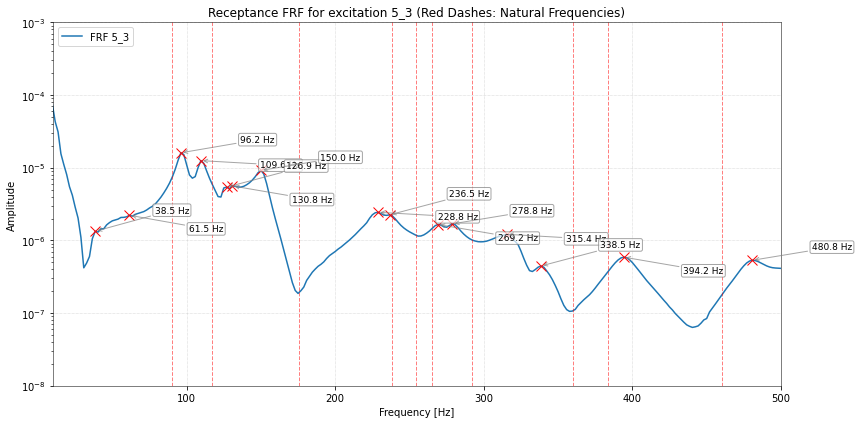

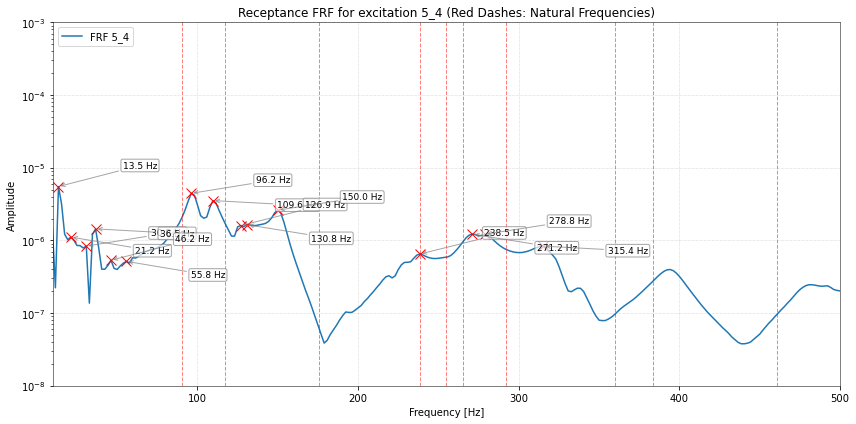

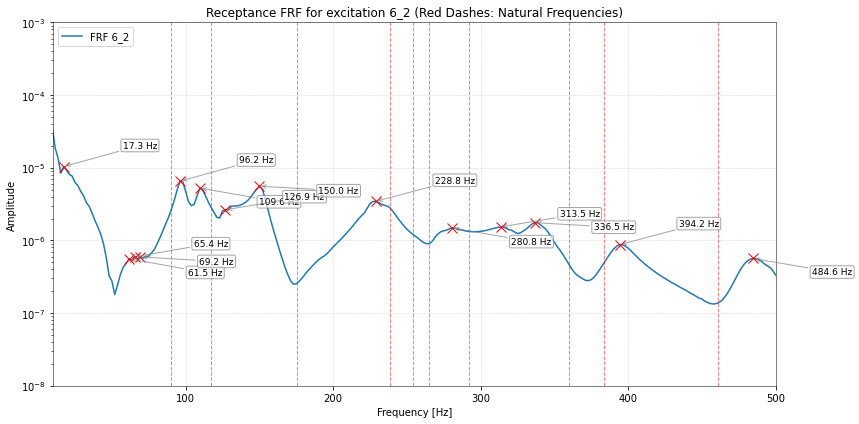

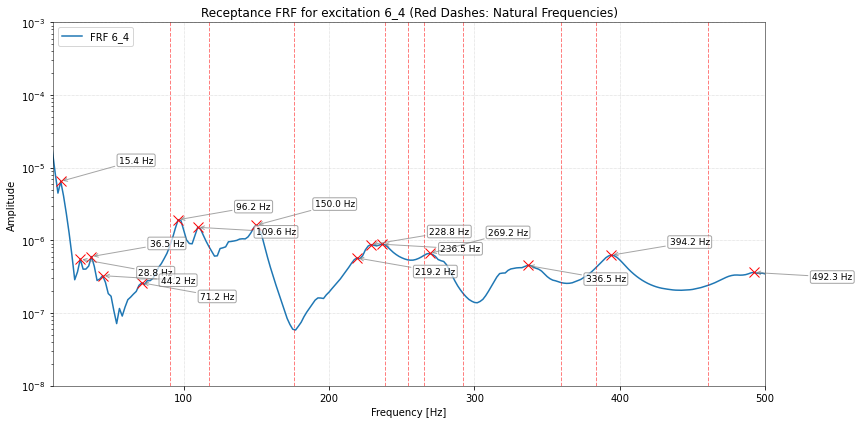

Selected natural frequencies [Hz]:
[ 96.15384615 125.         151.92307692 238.46153846 269.23076923
 269.23076923 280.76923077 348.07692308 388.46153846 473.07692308]


In [9]:
fn = np.zeros(10) # fill this array with the 10 frequencies you picked from the graph

# YOUR CODE HERE
from scipy.signal import find_peaks

fn_natural = [ 90.27687698, 117.31775428, 175.69534125, 238.50182961, 254.41077978,
 265.08306408, 292.08229899, 359.70245276, 383.69546858, 460.57030902]

# List of selected good excitation points (from hint)
selected_excitations = ['2_2', '2_3', '2_4', '3_3', '4_3', '5_2', '5_3', '5_4', '6_2', '6_4' ]
picked_freqs = []

# Collect all peaks for final frequency selection
all_peaks = []

# Loop through selected excitation points and plot
peak_idx = 0
for ex in selected_excitations:
    if ex not in fft_data:
        continue
    
    frf_data = fft_data[ex]['receptance'] 
    R = np.mean(frf_data, axis=1)  # average over runs
    mag = np.abs(R)
    
    # Find peaks (tune `height` or `prominence` as needed)
    peaks, properties = find_peaks(mag, prominence=1e-8)
    
    # Limit frequency range to visible range
    f_plot = freq[freq <= 500]
    mag_plot = mag[freq <= 500]
    
    # Store peaks for final frequency selection
    peak_freqs = freq[peaks][freq[peaks] <= 500]
    peak_mags = mag[peaks][freq[peaks] <= 500]
    all_peaks.extend(peak_freqs.tolist())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(f_plot, mag_plot, label=f"FRF {ex}")
    
    # ADDITION: Plot vertical lines at natural frequencies
    for f in fn_natural:
        if f <= 500:  # Only plot if within visible range
            plt.axvline(x=f, color='r', linestyle='--', alpha=0.5, linewidth=1)

    # Mark up to 15 most prominent peaks per figure
    if len(peak_freqs) > 0:
        # Sort by magnitude (most prominent first)
        sorted_indices = np.argsort(peak_mags)[::-1][:15]
        
        # Create annotation positions
        annotations = []
        
        for idx in sorted_indices:
            f_peak = peak_freqs[idx]
            m_peak = peak_mags[idx]
            plt.plot(f_peak, m_peak, 'rx', markersize=10)
            
            # Determine vertical position (staggered pattern)
            if idx % 4 == 0:  # 1st peak in group
                y_offset = m_peak * 1.8
            elif idx % 4 == 1:  # 2nd peak in group
                y_offset = m_peak * 0.6
            elif idx % 4 == 2:  # 3rd peak in group
                y_offset = m_peak * 1.4
            else:  # 4th peak in group
                y_offset = m_peak * 0.8
                
            annotations.append((f_peak, m_peak, y_offset))

        # Sort annotations by frequency to avoid crossing arrows
        annotations.sort(key=lambda x: x[0])
        
        # Add annotations with arrows
        for f_peak, m_peak, y_offset in annotations:
            plt.annotate(
                f"{f_peak:.1f} Hz", 
                xy=(f_peak, m_peak),
                xytext=(f_peak + 40, y_offset),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7),
                fontsize=9
            )

    plt.title(f"Receptance FRF for excitation {ex} (Red Dashes: Natural Frequencies)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.xlim(10,500)
    plt.ylim(1e-8,1e-3)
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Automatically select the best frequencies matching natural frequencies
fn_selected = []
for natural_freq in fn_natural:
    # Find closest detected peak
    closest_peak = min(all_peaks, key=lambda x: abs(x - natural_freq))
    fn_selected.append(closest_peak)
    
# Sort and take top 10
fn = np.sort(np.array(fn_selected))[:10]

# Final picked frequencies
print("Selected natural frequencies [Hz]:")
print(fn)

**Questions:**

* Which of the measurement points display the correct Eigenfrequencies?


YOUR ANSWER HERE

* What if different FRFs show multiple peaks in a very small frequency range? 

YOUR ANSWER HERE

* Which transfer function should be utilized to obtain the damping ratios?

YOUR ANSWER HERE

## 3 Determine natural frequencies and damping ratios of the plate

### 3.1 Half-Power Method - Exercise (2 Points)

__Task:__ Select 6 eigenfrequencies where the increase in amplitude is nicely visible and undisturbed. Apply the half-power method to the averaged FRF fo EX 5_2 and determine 6 modal damping coefficients. Make sure to include the one in the range of 350-450Hz! Lateron we will compare the modal damping of this eigenmode between the Half-Power method (HPM) and the Circle-Fitting method.
* choose 6 eigenfrequencies you determined using the peak-picking method, make sure to include the one in the range of 350-450 Hz (0.5 Points)
* for each eigenfrequency, determine the half power frequencies (1 Points)
* calculate the corresponding modal damping coefficient (0.5 Points)

__Hint:__ Determine a suitable frequency range around the eigenfrequency where you want to apply the HPM. Determine the half-power frequencies and eigenfrequency by using `numpy.argmin()` and similar functions.

In [10]:
fn = np.zeros(6) # select 6 eigenfrequencies
xi = np.zeros(6) # corresponding modal damping coefficients
fLR = np.zeros((6,2),dtype=int) # store the frequency range for half power method

# YOUR CODE HERE
fn = np.array([96.2, 151.9, 238.5, 280.8, 388.5, 473.1])  # Your 6 selected frequencies

key = '5_2'
R = fft_data_avg[key]['receptance_avg']  # Averaged FRF
mag = np.abs(R)
freq = np.fft.rfftfreq(2 * (len(mag) - 1), d=1 / SAMPLING_RATE)

# Apply frequency mask
freq_mask = (freq >= 30) & (freq <= 500)
freq = freq[freq_mask]
mag = mag[freq_mask]

# Loop over selected frequencies
for i in range(len(fn)):
    # Find the index closest to the target frequency
    peak_idx = np.argmin(np.abs(freq - fn[i]))
    A_peak = mag[peak_idx]
    A_half = A_peak / np.sqrt(2)

    # Find left index (f1) where amplitude drops below A_half
    f1 = peak_idx
    while f1 > 0 and mag[f1] > A_half:
        f1 -= 1

    # Find right index (f2) where amplitude drops below A_half
    f2 = peak_idx
    while f2 < len(mag) - 1 and mag[f2] > A_half:
        f2 += 1

    fLR[i, 0] = f1
    fLR[i, 1] = f2

    # Compute damping ratio
    xi[i] = (freq[f2] - freq[f1]) / (2 * fn[i])

# Output results
print("Mode |   fn [Hz]  |  f1 [Hz]  |  f2 [Hz]  |   xi")
print("-----|------------|-----------|-----------|--------")
for i in range(6):
    print(f" {i+1:3d} | {fn[i]:10.2f} | {freq[fLR[i,0]]:9.2f} | {freq[fLR[i,1]]:9.2f} | {xi[i]:.4f}")

Mode |   fn [Hz]  |  f1 [Hz]  |  f2 [Hz]  |   xi
-----|------------|-----------|-----------|--------
   1 |      96.20 |     92.31 |    100.00 | 0.0400
   2 |     151.90 |    138.46 |    155.77 | 0.0570
   3 |     238.50 |    207.69 |    242.31 | 0.0726
   4 |     280.80 |    265.38 |    290.38 | 0.0445
   5 |     388.50 |    373.08 |    401.92 | 0.0371
   6 |     473.10 |    465.38 |    498.08 | 0.0346


### 3.2 Circle-Fitting

__Task:__ Plot the averaged data of EX 5_2 in the Nyquist plane (as shown below). For the sake of visbility plot from 30-500 Hz.

<img src="./figs/nyquist_full.png"  width="50%">

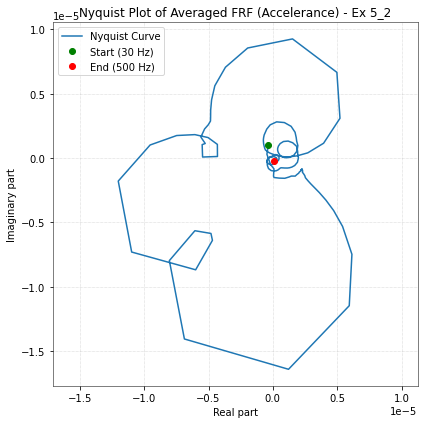

In [11]:
# plot the FRF (Receptance) of EX 5_2 in the Nyquist plane from 30 Hz to 500 Hz

# YOUR CODE HERE
# Select the excitation point
excitation_point = '5_2'

# Choose either 'accelerance_avg' or 'receptance_avg' to plot
FRF_complex = fft_data_avg[excitation_point]['receptance_avg']  # Or use 'receptance_avg'

# Frequency vector (same length as FRF)
N = 2 * (len(FRF_complex) - 1)
frequencies = np.fft.rfftfreq(N, d=1/SAMPLING_RATE)

# Filter for desired frequency range (30 to 500 Hz)
mask = (frequencies >= 30) & (frequencies <= 500)
f_plot = frequencies[mask]
FRF_plot = FRF_complex[mask]

# Plot in the Nyquist plane
plt.figure(figsize=(6, 6))
plt.plot(FRF_plot.real, FRF_plot.imag, label='Nyquist Curve')
plt.plot(FRF_plot.real[0], FRF_plot.imag[0], 'go', label='Start (30 Hz)')
plt.plot(FRF_plot.real[-1], FRF_plot.imag[-1], 'ro', label='End (500 Hz)')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title(f"Nyquist Plot of Averaged FRF (Accelerance) - Ex {excitation_point}")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

__Task:__ Again plot the FRF in the Nyquist plane, but this time for a frequency range of 350-470 Hz. You should be able to see somewhat of a circular-like contour. Additionally select the frequency range for which you want to perform the circle fitting and plot the data for this frequency range as well. This data should only contain parts of the circle!

<img src="./figs/nyquist_eigenfreq_new.png"  width="40%">

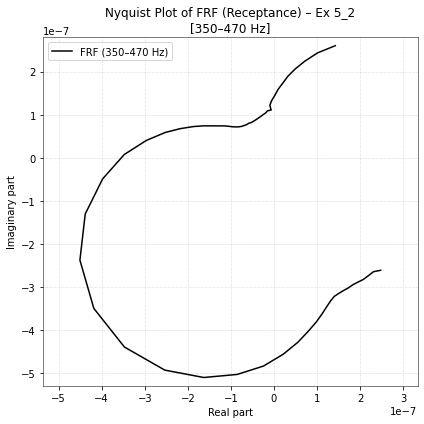

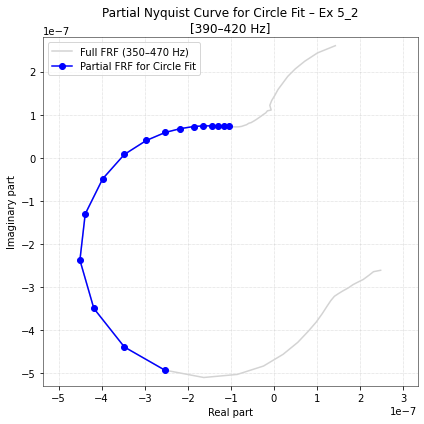

In [12]:
# plot from 350-470Hz
# YOUR CODE HERE
# Step 1: Nyquist plot from 350 to 470 Hz
excitation_point = '5_2'
FRF_complex = fft_data_avg[excitation_point]['receptance_avg']  # Choose 'receptance_avg' if needed

N = 2 * (len(FRF_complex) - 1)
frequencies = np.fft.rfftfreq(N, d=1/SAMPLING_RATE)

# Frequency range mask: 350–470 Hz
mask_full = (frequencies >= 350) & (frequencies <= 470)
f_plot = frequencies[mask_full]
FRF_plot = FRF_complex[mask_full]

# Plot full circle-like contour
plt.figure(figsize=(6, 6))
plt.plot(FRF_plot.real, FRF_plot.imag, 'k-', label='FRF (350–470 Hz)')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title(f"Nyquist Plot of FRF (Receptance) – Ex {excitation_point}\n[350–470 Hz]")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

# choose a frequency range where only the circle is included
re = 0 # real part of FRF from fmin to fmax => shape depends on how many frequencies you include!
im = 0 # imagniary part of FRF ....
freqLR = 0 # frequencies you include in the circle-fitting
# e.g. freqLR = freq[iL:iR]
# L...index of left/lowest frequency
# R...index of right/highest frequency
# YOUR CODE HERE


# Step 2: Choose subset of circle data for fitting (e.g., resonant mode area only)
# Manually pick a zoom-in range, e.g. 390–420 Hz
iL = np.searchsorted(frequencies, 390)
iR = np.searchsorted(frequencies, 420)
freqLR = frequencies[iL:iR]
FRF_circle_segment = FRF_complex[iL:iR]
re = FRF_circle_segment.real
im = FRF_circle_segment.imag

# Plot the partial circle segment
plt.figure(figsize=(6, 6))
plt.plot(FRF_plot.real, FRF_plot.imag, 'lightgray', label='Full FRF (350–470 Hz)')
plt.plot(re, im, 'b-o', label='Partial FRF for Circle Fit')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title(f"Partial Nyquist Curve for Circle Fit – Ex {excitation_point}\n[390–420 Hz]")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

The circle is described by 3 variables: a,b and c. By defining an error function and minimizing it (least squares routine) we can fit the circle to the data (eq. 24-26 in the [lecture slides](./slides-5_IdentificationMethods.pdf)). By calculating the partial derivatives of the error function we can setup a linear system which we can solve (eq. 27). 

__Task:__ Calculate the coefficients of the linear system and solve it for a,b,c.

__Hint:__ Solve the linear system Ax=b with `scipy.linalg.solve` instead of inverting the matrix. By setting `scipy.linalg.solve(..., assume_a='sym')` we can use the symmetry of the matrix and be more efficient.

In [13]:
# coefficients of linear system
# YOUR CODE HERE
raise NotImplementedError()

# setup A by filling it with the coefficients
A = np.zeros((3,3))
# YOUR CODE HERE
raise NotImplementedError()

# setub b by filling it with the coefficients
b = np.zeros((3,1))
# YOUR CODE HERE
raise NotImplementedError()

# solve 
a = np.zeros(3) # a = [a,b,c] => contains the parameters for the circle
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

__Task:__ Now obtain the circle parameters M (mid point) and R (radius) with equations (25) and below (28) in the text. Plot the FRF in your determined frequency range in the Nyquist plane and the circle with its mid point. Therefore we can check if we worked correctly.

__Hint:__ You can generate a circle with `circle = plt.Circle` and then add it to the subplot by `ax.add_patch(circle)`.

<img src="./figs/nyquist_circle_new.png"  width="30%">

In [ ]:
# obtain circle mid point and radius
R = 0 # radius
M = 0+1j*0 # mid point
# YOUR CODE HERE
raise NotImplementedError()

# plot
# YOUR CODE HERE
raise NotImplementedError()

Next we have to determine the frequency spacing $\gamma$. This is done by taking two vectors which reach from the mid point of the circle to succeeding points and calculating the angle between them. With this we can determine the natural frequency, which is located where $\frac{\partial^2 \omega}{\partial \gamma^2}=0$ and $\frac{\partial \omega}{\partial \gamma}$ is maximum.

__Task:__ Determine at which index (jmax) the first derivative $\frac{\partial \omega}{\partial \gamma}$ reaches its maximum, as well as the index before the second derivatives switches signs (ja) and the index after the second derivative switches signs (jb). Use `np.gradient` to calculate the derivatives.

__Hint:__ The angle between two vectors is determined by $cos(\gamma) = \frac{\langle \mathbf{a} , \mathbf{b} \rangle}{|\mathbf{a}||\mathbf{b}|}$.

__Hint:__ Check if you really found the correct indices by plotting $\gamma$, its derivatives and highlight the determined indices with vertical lines (`ax.axvline`)!

<img src="./figs/gamma_and_derivatives_new.png"  width="70%">

In [ ]:
# get gamma
gamma = np.zeros(L-1)
# YOUR CODE HERE
raise NotImplementedError()

# find where first derivative is maximum and second passes zero
jmax = 0 # index where first derivative of gamma is maximum
ja = 0 # index before second derivative of gamma switches sign (omega_a)
jb = 0 # index after second derivative of gamma switches sign (omega_b)
dgamma = np.zeros_like(gamma) # first derivative
ddgamma = np.zeros_like(gamma) # second derivative
# YOUR CODE HERE
raise NotImplementedError()

# plot to verify correct indices
# YOUR CODE HERE
raise NotImplementedError()

__Task:__ Linearly interpolate the second derivative of gamma between $\omega_a$ and $\omega_b$ and find the eigenfrequency. Plot the interpolated function and highlight the determined index where the eigenfrequency is located with a vertical line!

__Hint:__ Use `scipy.interpolate.interp1d` to setup an interpolation function and then interpolate with it.

<img src="./figs/gamma_interp_new.png"  width="60%">

In [ ]:
# interpolate ddgamma between ja and jb
wfreqInterp = np.zeros(1000) # fine resolved frequency array between w_a and w_b
ddgammaInterp = np.zeros(1000) # interpolated second derivative of gamma
# YOUR CODE HERE
raise NotImplementedError()

# find eigenfrequency (where the interpolated ddgamma is closest to 0)
fEig = 0 # eigenfrequency
# YOUR CODE HERE
raise NotImplementedError()

# plot to verify
# YOUR CODE HERE
raise NotImplementedError()

__Task:__ Determine D (point opposite of eigenfrequency). Plot the FRF for all frequencies you determined to be relevant for the fitting, the circle, M, D, the point where the eigenfrequency is located ($\omega_k$), as well as the points where $\omega_a$ and $\omega_b$ are located. Additionally connect D with the points of $\omega_a$, $\omega_b$ and $\omega_k$. Your figure should look similar to the one depicted on p.25 in the slides.

__Hint:__ First determine the angle of the point of the eigenfrequency and then add pi (flip to opposite side). Do this by interpolating the real and imaginary part of the FRF between $\omega_a$ and $\omega_b$.

<img src="./figs/nyquist_all_new.png" width="40%">

In [ ]:
# interpolate re and im between ja and jb and determine re and im of the point at which the eigenfrequency occurs
reEig = 0 # real part of point at eigenfrequency
imEig = 0 # imaginary part of point at eigenfrequency
# YOUR CODE HERE
raise NotImplementedError()

# determine D by calculating the angle of the vector from M to Eig and turn it by pi
# don't use the length of this vector, instead use the calculated radius of the circle R!
D = 0+1j*0
# YOUR CODE HERE
raise NotImplementedError()

# plot to verify
# YOUR CODE HERE
raise NotImplementedError()

__Task:__ Determine the angles $\Delta\phi_a$ (angle between $\omega_a$ and $\omega_k$) and $\Delta\phi_b$ (angle between $\omega_b$ and $\omega_k$) by using the dot product and calculate the modal damping coefficient.

In [ ]:
# determine delta phi_a and delta phi_b
phia = 0
phib = 0
# YOUR CODE HERE
raise NotImplementedError()

# calculate modal damping coefficient (eq. 29)
xiCF = 0 # modal damping coefficient
# YOUR CODE HERE
raise NotImplementedError()

phia, phib, xiCF

__Question:__ Is the modal damping obtained by circle fitting the same as the one obtained by the Half-Power Method? What might be the sources of error?

YOUR ANSWER HERE

__Question:__ What does the modification of the circle fitting error function mean?

YOUR ANSWER HERE

__Question:__ How is the damping ratio obtained using circle fitting?

YOUR ANSWER HERE

## 4 Compute the Mode-shapes of the plate - Exercise (4 Points)

Select the averaged FRF data for all excitation points at the 6 eigenfrequencies you determined earlier with the half-power method and create 6 contour plots, visualizing the shape of oscillation. This can be done by calculating the modal constants to obtain the oscillation shape (p. 18 in the slides).

__Task:__ Compute the modal constants $\mathbf{C}$ and oscillation shapes $\mathbf{v}$ for all excitation points. (1.5 points)
* for the frequencies you chose from the previous practice, compute the modal constants $\mathbf{C}$ (1 Point)
* compute the corresponding mode shapes $\mathbf{v}$ (0.5 Points)

__Notes:__ The FE model and the real plate have the same dimension but different orientation, so for comparison of the mode shapes, think about how to rotate our measured plate to match the orientation of both plates.

In [29]:
C = np.zeros((4,6,6), dtype=np.complex_) # modal constant matrix (4 rows, 6 columns, 6 eigenfrequencies)
v = np.zeros((4,6,6), dtype=np.complex_) # oscillation shapes (4 rows, 6 columns, 6 eigenfrequencies)

EX_matrix = np.zeros((4,6),dtype=object) # matrix that store the name of the Excitation points

for i in range(4,0,-1):
    for j in range(6):
        # print("%d_%d" % (i, j+1))
        EX_matrix[abs(i-4),j] = "%d_%d" % (j+1, i)

print(EX_matrix)

# determine modal constants oscillation shape where excitation and measurement point
# measurement point is located at 3_3!

# YOUR CODE HERE
# Compute modal constants C_ab,k using the formula from the slide
for i in range(4):
    for j in range(6):
        ex_name = EX_matrix[i, j]
        if ex_name in fft_data_avg:
            R = fft_data_avg[ex_name]['receptance_avg']
            for k in range(6):
                idx = np.argmin(np.abs(freq - fn[k]))
                # Use the slide formula: C_ab,k = H_ab(omega_k) * 2j * xi_k * omega_k^2
                C[i, j, k] = R[idx] * 2j * xi[k] * (2 * np.pi * fn[k])**2

# For each mode, use the drive-point FRF (center 3_3) to get v_ak, then compute v_bk for all points
for k in range(6):
    i0, j0 = 2, 2  # center point (3_3)
    v_ak = np.sqrt(C[i0, j0, k])
    for i in range(4):
        for j in range(6):
            v[i, j, k] = C[i, j, k] / v_ak if v_ak != 0 else 0
    # Normalize mode shape for each mode (max abs = 1)
    max_abs = np.max(np.abs(v[:, :, k]))
    if max_abs > 0:
        v[:, :, k] /= max_abs

[['1_4' '2_4' '3_4' '4_4' '5_4' '6_4']
 ['1_3' '2_3' '3_3' '4_3' '5_3' '6_3']
 ['1_2' '2_2' '3_2' '4_2' '5_2' '6_2']
 ['1_1' '2_1' '3_1' '4_1' '5_1' '6_1']]


__Task:__ Create the contourplots with the oscillation shape data. Make sure to plot it in a way that the plate is oriented in the right way and coordinates are displayed. (1.5 Points: 1 Point for correct plot, 0.5 Points for good formatting)

__Hint:__ Take a look at the `plotmodes` function below. Additionally there is a tutorial available under [https://www.tutorialspoint.com/matplotlib/matplotlib_contour_plot.htm](https://www.tutorialspoint.com/matplotlib/matplotlib_contour_plot.htm):
```python
import numpy as np
import matplotlib.pyplot as plt
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()
```

Some example plots of the measured mode shapes are provided for you:

<img src='./figs/mode_1.png' width='30%'>
<img src='./figs/mode_2.png' width='30%'>
<img src='./figs/mode_3.png' width='30%'>

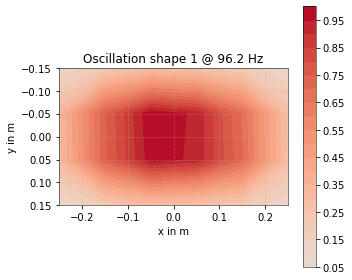

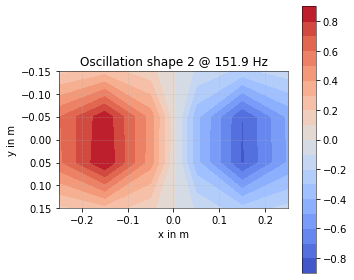

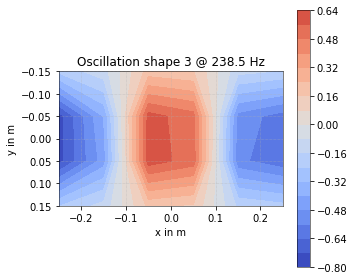

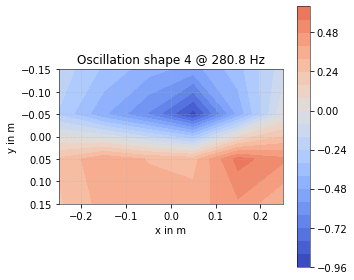

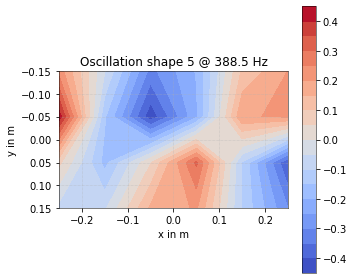

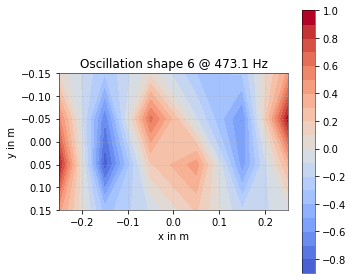

In [30]:
# contourplot
# YOUR CODE HERE
# Contour plots for each mode shape (6 plots)
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-0.25, 0.25, 6)   # 6 columns
y = np.linspace(-0.15, 0.15, 4) # 4 rows
X, Y = np.meshgrid(x, y)

for k in range(6):
    fig, ax = plt.subplots(figsize=(5, 4))
    # Real part of mode shape
    Z = v[:, :, k].real
    lim = np.max(np.abs(Z))
    cp = ax.contourf(X, Y, Z, levels=20, cmap='coolwarm', vmin=-lim, vmax=lim)
    fig.colorbar(cp)
    ax.set_title(f"Oscillation shape {k+1} @ {fn[k]:.1f} Hz")
    ax.set_xlabel("x in m")
    ax.set_ylabel("y in m")
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

Now we compare the experimental oscillation shapes with the modeshapes from our FE-system from exercise 3. In this step we want to compare them visually, so we need to plot the modeshapes.

__Task:__ Obtain the modeshapes by solving the EVP and __plot__ them using the nullspace (0.5 Points).

__Hint:__ Use the code from homework 3.

In [31]:
from scipy import sparse
from scipy.io import mminfo,mmread
from utlity_functions import nullspace

M = sparse.csc_matrix(mmread('Ms.mtx'))#.toarray() # mass matrix
K = sparse.csc_matrix(mmread('Ks.mtx'))#.toarray() # stiffness matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes
N = X.shape[0] # number of nodes

# constrain all edges
tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.hstack([Nn,No,Ns,Nw])

# select a point for the excitation
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))
# center
N0 = np.argmin(np.sum((X)**2,axis=1))

# select top of the plate
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol)[:,0]

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
#If = np.array([Ix[Ns],Iy[Ns],Iz[Ns]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# for plotting
nprec = 6 # precision for finding uniqe values
# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
xv = np.unique(np.round(X[:,0],decimals=nprec))
yv = np.unique(np.round(X[:,1],decimals=nprec))
zv = np.unique(np.round(X[:,2],decimals=nprec))

def plotmodes(V) :
    for i,v in enumerate(V.T) : # iterate over eigenvectors
        c = np.reshape(v[Iz[Nt]],[len(yv),len(xv)])
        lim = np.max(np.abs(c))
        fig,ax = plt.subplots(figsize=[3.5,2])
        cp = ax.contourf(xv,yv,c,cmap=plt.get_cmap('coolwarm'),vmin=-lim,vmax=lim)
        ax.set_aspect('equal')
        fig.colorbar(cp)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()

[ 90.27687698 117.31775427 175.69534125 238.50182961 254.41077978
 265.08306408 292.08229899 359.70245276 383.69546858 460.57030902]


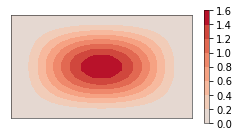

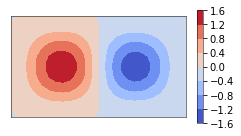

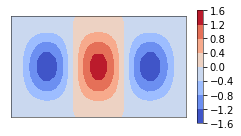

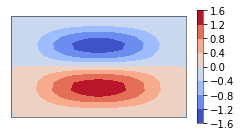

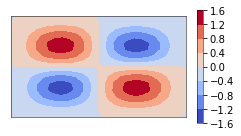

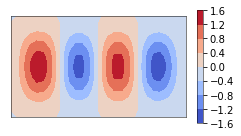

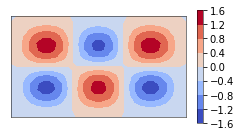

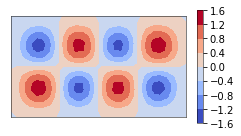

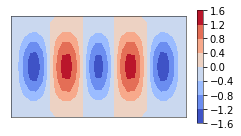

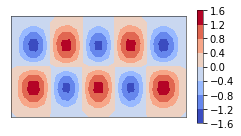

In [32]:
# 1. setup the nullspace
# (Find the nullspace of the constraint matrix to get the transformation matrix Q)
from utlity_functions import nullspace
import numpy as np

# Build the constraint matrix for fixed DoFs
B = np.eye(K.shape[0])[Ic]  # Select rows for constrained DoFs
Q = nullspace(B)            # Q is the nullspace transformation matrix

# 2. constrain the system
Kc = Q.T @ K @ Q
Mc = Q.T @ M @ Q

# 3. calculate the modeshapes and eigenfrequencies
from scipy.sparse.linalg import eigsh
Wc, Vc = eigsh(Kc, k=10, M=Mc, sigma=0, which='LM')

# 4. obtain modeshape in unconstrained sorting (expand to full system)
V = Q @ Vc  # Transform back to full system

# plot the modes
print(np.sqrt(Wc)/2/np.pi)
plotmodes(V)

__Question:__ Based on the visual comparison, which of the FE modes have you identified by peak-picking? (0.5 Points)

YOUR ANSWER HERE

## 5 Compare experimental identification

Compare the calculated Eigenfrequencies and modes computed with peak picking to the modes of the FE model of the plate (Exercises 1-3) using the MAC factor.

__Task:__ Calculate the MAC of all oscillation shapes and modeshapes. This should result in a 10x6 matrix where the elements indicate the similarity between the corresponding oscillation shapes and modeshape.

__Hint:__ You will have to modify the eigenvectors to only include elements which correspond to the excitation points along the grid. You can do this via the coordinate matrix $\mathbf{X}$.

__Hint:__ You can flatten a matrix by adding `.ravel()` at the end. This is required for the calculation of the MAC.

In [ ]:
# fill the modified modeshape matrix with the right elements
w = np.zeros((4,6,10)) # modified modeshape matrix 4 rows 6 colums 10 frequencies
# YOUR CODE HERE
raise NotImplementedError()

# calculate the MAC
MAC = np.zeros((6,10)) # MAC matrix
# YOUR CODE HERE
raise NotImplementedError()

__Task:__ Plot the MAC matrix to gain overview.

__Hint:__ You can plot matrices with `plt.matshow`. With the option `cmaps=` you can choose colormaps. Select one that is white at 0 and linearly increases in one colortone up until 1.

__Hint:__ With `mpl_toolkits.axes_grid1.make_axes_locable`, `divider.append_axes` and `plt.colorbar` you can create a colorbar right next to the plot, which indicates the value related to a colortone.

<img src='./figs/MAC_new.png' width='50%'>

In [ ]:
# colorful plot of the MAC matrix
# YOUR CODE HERE
raise NotImplementedError()

__Question:__ Does the analysis via MAC support your previous statement about which modes you have identified via peak-picking?

YOUR ANSWER HERE

__Question:__ Why does the MAC show correlations with several modeshapes for one oscillation shape?

YOUR ANSWER HERE

__Question:__ Discuss potential discrepancies between the oscillation shapes and the modeshapes. How does this affect the MAC?

YOUR ANSWER HERE